In [1]:
# !pip install datasets
# !pip install accelerate
# !pip install ultralytics
# !pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

ValueError: mount failed

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt

In [ ]:
import torch
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from PIL import Image

def crop_image(image, box):
    additional_area = 1/10
    x_min, y_min, x_max, y_max = box
    width, height = image.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width*additional_area)
    y_min_2 = max(0, y_min - box_height*additional_area)
    x_max_2 = min(width, x_max + box_width*additional_area)
    y_max_2 = min(height, y_max + box_height*additional_area)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = image.crop(area)
    return cropped_img

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.set_device(0)
model_detect = YOLO('yolov8n.pt')
model_detect.classes = [0]

def recieve_box(image):
    results = model_detect(source = image, classes=0, show = False, imgsz=640, conf=0.2, iou=0.4, save = False, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    cropped_images = []
    for box in boxes:
        cropped_images.append(crop_image(image, box))
    return cropped_images

In [ ]:
device

'cuda'

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict, concatenate_datasets
from datasets.features import ClassLabel
from tqdm.auto import tqdm

def get_zoomed_dataset(data_dir):
  ds_demo = load_dataset("imagefolder", data_dir=data_dir)

  dict_detected = {'image' : [], 'labels': []}
  for i in tqdm(range(ds_demo['train'].num_rows)):
    img = recieve_box(ds_demo['train'][i]['image'])
    label = ds_demo['train'][i]['labels']
    if(len(img) > 0):
      dict_detected['image'].append(img[0])
      dict_detected['labels'].append(label)

  return Dataset.from_dict(dict_detected)


def get_dataset(need_split_train, data_train_dirs, data_test_dirs):
  train_datasets = []
  for data_dir in data_train_dirs:
    train_datasets.append(get_zoomed_dataset(data_dir))

  test_datasets = []
  for data_dir in data_test_dirs:
    test_datasets.append(get_zoomed_dataset(data_dir))

  ###
  for i in range(len(need_split_train)):
    if need_split_train[i]:
      train_datasets[i] = train_datasets[i].train_test_split(test_size=0.1)

      test_datasets.append(train_datasets[i]["test"])
      train_datasets[i] = train_datasets[i]["train"]
  ###
  ds_test_detected = concatenate_datasets(test_datasets)
  ds_train_detected = concatenate_datasets(train_datasets)

  return DatasetDict({
    'train': ds_train_detected,
    'test': ds_test_detected,
  })

In [ ]:
need_split_train = [False, False]

data_train_dirs = [
    "/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/train",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/test",
    "/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/train",
    "/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/valid",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/test",
    ##"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_video_frames/frames"
    ]

data_test_dirs = [
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/train",
    "/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_1/test",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/train",
    #"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/valid",
    "/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_images_2/test",
    ##"/content/drive/MyDrive/ml2/ML_project_2_course/datasets/shoplifting_video_frames/frames"
    ]


ds_detected = get_dataset(need_split_train, data_train_dirs, data_test_dirs)



Resolving data files:   0%|          | 0/2186 [00:00<?, ?it/s]

  0%|          | 0/2185 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/752 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/214 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/316 [00:00<?, ?it/s]

  0%|          | 0/315 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
ds_detected = ds_detected.class_encode_column("labels")

Stringifying the column:   0%|          | 0/3144 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3144 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/423 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/423 [00:00<?, ? examples/s]

In [ ]:
ds_detected

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 3144
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 423
    })
})

In [ ]:
from transformers import ViTImageProcessor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')

# from transformers import AutoImageProcessor
# processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")

# from transformers import EfficientNetImageProcessor
# processor = EfficientNetImageProcessor.from_pretrained('google/efficientnet-b4')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
def process_example(example):
    inputs = processor(example['image'], return_tensors='pt')
    inputs['labels'] = example['labels']
    return inputs

In [ ]:
process_example(ds_detected['train'][0])

{'pixel_values': tensor([[[[-0.3647, -0.3882, -0.4039,  ..., -0.7255, -0.7725, -0.8118],
          [-0.3647, -0.3882, -0.4039,  ..., -0.7490, -0.7882, -0.8275],
          [-0.3647, -0.3882, -0.4039,  ..., -0.7725, -0.8039, -0.8196],
          ...,
          [-0.3725, -0.2471, -0.2314,  ..., -0.5216, -0.5529, -0.5294],
          [-0.0588, -0.0667, -0.4275,  ..., -0.4980, -0.5137, -0.5294],
          [-0.2706,  0.1529, -0.2314,  ..., -0.5373, -0.5216, -0.5529]],

         [[-0.4039, -0.4118, -0.4275,  ..., -0.7333, -0.7725, -0.8118],
          [-0.4039, -0.4118, -0.4275,  ..., -0.7569, -0.7882, -0.8275],
          [-0.4039, -0.4118, -0.4275,  ..., -0.7804, -0.8039, -0.8196],
          ...,
          [-0.5922, -0.4824, -0.4824,  ..., -0.4667, -0.4980, -0.4745],
          [-0.2784, -0.3098, -0.6941,  ..., -0.4431, -0.4588, -0.4745],
          [-0.4902, -0.0980, -0.4980,  ..., -0.4824, -0.4667, -0.4980]],

         [[-0.4510, -0.4667, -0.4824,  ..., -0.7490, -0.7882, -0.8275],
          [-0

In [ ]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['labels']
    return inputs

In [ ]:
prepared_ds = ds_detected.with_transform(transform)

In [ ]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 3144
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 423
    })
})

In [ ]:
from torch import nn

labels = ds_detected['train'].features['labels'].names

from transformers import ViTForImageClassification
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

# from transformers import AutoModelForImageClassification
# model = AutoModelForImageClassification.from_pretrained(
#     'microsoft/resnet-50',
#     num_labels=len(labels),
#     ignore_mismatched_sizes=True,
#     id2label={str(i): c for i, c in enumerate(labels)},
#     label2id={c: str(i) for i, c in enumerate(labels)}
# )

# from transformers import EfficientNetForImageClassification
# model = EfficientNetForImageClassification.from_pretrained(
#     'google/efficientnet-b4',
#     num_labels=len(labels),
#     ignore_mismatched_sizes=True,
#     id2label={str(i): c for i, c in enumerate(labels)},
#     label2id={c: str(i) for i, c in enumerate(labels)}
# )


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# model.classifier[1].state_dict()

In [ ]:
# for param in model.classifier[1].parameters():
#     param.data =  torch.randn_like(param)

In [ ]:
# model.classifier[1].state_dict()

In [ ]:
from torch.utils.data import DataLoader

batch_size = 16
train_dataloader = DataLoader(prepared_ds["train"], shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(prepared_ds["test"], batch_size=batch_size)

In [ ]:
import evaluate
from torch.optim import AdamW, SGD, Adamax
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr=2e-6, weight_decay=1e-1)
#optimizer = SGD(model.parameters(), lr=2e-4, momentum=0.9, nesterov=True)
#optimizer = Adamax(model.parameters(), lr=2e-4)

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = get_scheduler(
	name = 'linear',
	optimizer = optimizer,
	num_warmup_steps = 0,
	num_training_steps = num_training_steps)

device = 'cuda'
model.to(device)
metric = evaluate.load('f1')

for epoch in tqdm(range(num_epochs)):
  model.train()
  for batch in tqdm(train_dataloader, leave=False):
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()


  model.eval()
  for batch in tqdm(test_dataloader, leave=False):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    metric.add_batch(predictions=predictions, references=batch['labels'])

  print(f'epoch {epoch} -', metric.compute())

model.save_pretrained("/content/drive/MyDrive/ml2/ML_project_2_course/weights3")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch 0 - {'f1': 0.9583333333333334}


  0%|          | 0/197 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

epoch 1 - {'f1': 0.9583333333333334}


In [ ]:
# def collate_fn(batch):
#     return {
#         'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
#         'labels': torch.tensor([x['labels'] for x in batch])
#     }

In [ ]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#   output_dir="/content/drive/MyDrive/ml2/ML_project_2_course/weights2",
#   per_device_train_batch_size=16,
#   evaluation_strategy="steps",
#   num_train_epochs=30,
#   fp16=True,
#   save_steps=200,
#   eval_steps=200,
#   save_total_limit=1,
#   logging_steps=10,
#   learning_rate=2e-5,
#   weight_decay=0.001,
#   remove_unused_columns=False,
#   push_to_hub=False,
#   report_to='none',
#   load_best_model_at_end=True,
# )

In [ ]:
# from datasets import load_metric

# metric = load_metric('f1')

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

# metric = load_metric('roc_auc')
# softmax = torch.nn.Softmax()

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = float(softmax(logits)[0][1])
#     return metric.compute(prediction_scores=predictions, references=labels)



In [ ]:
# from transformers import Trainer

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     data_collator=collate_fn,
#     compute_metrics=compute_metrics,
#     train_dataset=prepared_ds["train"],
#     eval_dataset=prepared_ds["test"],
#     tokenizer=processor,
# )

In [ ]:
# train_results = trainer.train()
# trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
# trainer.save_state()

In [ ]:
# metrics = trainer.evaluate(prepared_ds['test'])
# trainer.log_metrics("eval", metrics)
# trainer.save_metrics("eval", metrics)

In [ ]:
prepared_ds['test']

Dataset({
    features: ['image', 'labels'],
    num_rows: 423
})

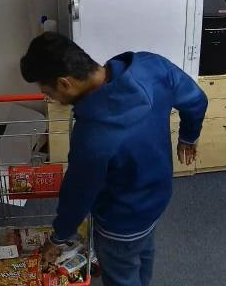

In [ ]:
ex = ds_detected['test'][100]
ex['image']

In [ ]:
ex['labels']

0

In [ ]:
# logits = model(**inputs).logits

# logits

In [ ]:
logits = model(inputs['pixel_values'].to(device)).logits

logits

tensor([[ 1.7472, -1.8297]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
 logits.argmax(-1).item()

0

In [ ]:
# array = np.array(ds_train["train"]['labels'])
# array.sum()/array.shape[0]

In [ ]:
softmax = torch.nn.Softmax()

def image_to_prob(img):
    inputs = processor(img, return_tensors='pt')
    logits = model(inputs['pixel_values'].to(device)).logits
    return float(softmax(logits)[0][1])

In [ ]:
logits.cpu().data.numpy()

array([[     1.7472,     -1.8297]], dtype=float32)

In [ ]:
def get_logits(img):
    inputs = processor(img, return_tensors='pt')
    return model(inputs['pixel_values'].to(device)).logits.cpu().data.numpy()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# logits_test = []
# for i in tqdm(range(0, ds_detected['test'].num_rows)):
#   logits_test.append(get_logits(ds_detected['test'][i]['image']))
#   #logits_test.append(image_to_prob(ds_detected['test'][i]['image']))

In [ ]:
# preds = np.array(logits_test).argmax(-1).flatten()

In [ ]:
probs = []
for i in tqdm(range(0, ds_detected['test'].num_rows)):
  probs.append(image_to_prob(ds_detected['test'][i]['image']))

  0%|          | 0/423 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(ds_detected['test']['labels'], probs)

0.9932423360930858

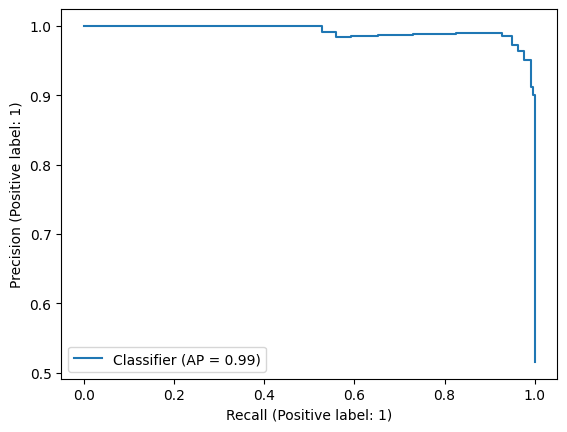

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_predictions(ds_detected['test']['labels'], probs)
plt.show()

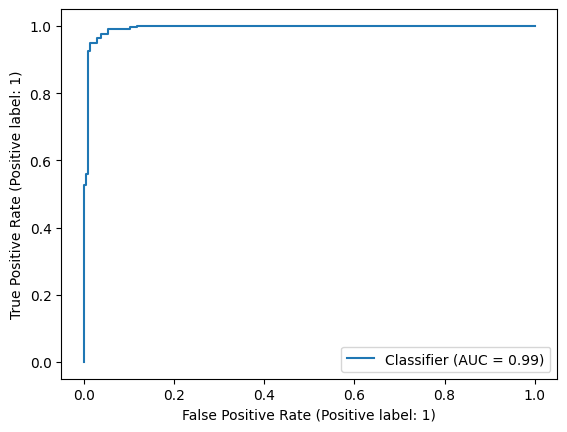

In [ ]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(ds_detected['test']['labels'], probs)
plt.show()

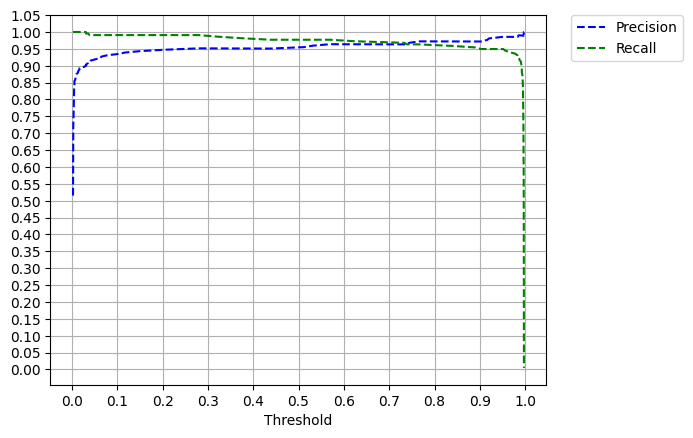

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(ds_detected['test']['labels'], probs)

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
  plt.xlabel("Threshold")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xticks(np.arange(0, 1.1, 0.1))
  plt.yticks(np.arange(0, 1.1, 0.05))
  plt.grid(True)

plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

In [ ]:
def image_to_prob(img):
    inputs = processor(img, return_tensors='pt')
    logits = model(inputs['pixel_values'].to(device)).logits
    return float(softmax(logits)[0][1])

In [ ]:
def crop_image(image, box):
    additional_area = 1/10
    x_min, y_min, x_max, y_max = box
    width, height = image.size
    box_width = x_max - x_min
    box_height = y_max - y_min
    x_min_2 = max(0, x_min - box_width*additional_area)
    y_min_2 = max(0, y_min - box_height*additional_area)
    x_max_2 = min(width, x_max + box_width*additional_area)
    y_max_2 = min(height, y_max + box_height*additional_area)
    area = (x_min_2, y_min_2, x_max_2, y_max_2)
    cropped_img = image.crop(area)
    return cropped_img

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def recieve_box(image):
    results = model_detect(source = image, classes=0, show = False, imgsz=640, conf=0.2, iou=0.4, save = False, verbose=False)
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    cropped_images = []
    for box in boxes:
        cropped_images.append(crop_image(image, box))
    return cropped_images

In [ ]:
from google.colab.patches import cv2_imshow

import cv2
from ultralytics import YOLO
import random
from PIL import Image

def draw_bounding_boxes_without_id(frame, results):
    boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
    classes = results[0].boxes.cls.cpu().numpy().astype(int)

    for box, clss in zip(boxes, classes):
        # Generate a random color for each object based on its ID
        if clss != 0:
            random.seed(int(clss)+8)
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

            cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3],), color, 2)
            cv2.putText(
                frame,
                f"{model.model.names[clss]}",
                (box[0], box[1]),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                (50, 255, 50),
                2,
            )
    return frame


def process_video_with_tracking(model, input_video_path, show_video=True, save_video=False, output_video_path="output_video.mp4"):
    # Open the input video file
    cap = cv2.VideoCapture(input_video_path)

    if not cap.isOpened():
        raise Exception("Error: Could not open video file.")

    # Get input video frame rate and dimensions
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the output video writer
    if save_video:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        results = model.track(frame, iou=0.4, conf=0.25, persist=True, imgsz=608, verbose=False, tracker="bytetrack.yaml", classes=0)

        if results[0].boxes.id != None: # this will ensure that id is not None -> exist tracks
            boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
            ids = results[0].boxes.id.cpu().numpy().astype(int)

            for box, id in zip(boxes, ids):
                # Generate a random color for each object based on its ID
                random.seed(int(id))
                color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                additional_area = 1/10
                x_min, y_min, x_max, y_max = box
                width, height = frame_width, frame_height
                box_width = x_max - x_min
                box_height = y_max - y_min
                x_min_2 = max(0, x_min - box_width*additional_area)
                y_min_2 = max(0, y_min - box_height*additional_area)
                x_max_2 = min(width, x_max + box_width*additional_area)
                y_max_2 = min(height, y_max + box_height*additional_area)
                area = (x_min_2, y_min_2, x_max_2, y_max_2)
                cropped_img = Image.fromarray(frame, 'RGB').crop(area)

                prob = image_to_prob(cropped_img)

                cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3],), color, 2)
                cv2.putText(
                    frame,
                    f"{prob:.2f}",
                    (box[0], box[1]),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.70,
                    (0, 255, 255),
                    2,
                )

        if save_video:
            out.write(frame)

        if show_video:
            frame = cv2.resize(frame, (0, 0), fx=0.75, fy=0.75)
            #cv2.imshow("frame", frame)
            cv2_imshow(frame)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # Release the input video capture and output video writer
    cap.release()
    if save_video:
        out.release()

    # Close all OpenCV windows
    cv2.destroyAllWindows()
    return results

# Example usage:
model1 = YOLO('yolov8n.pt')
model1.fuse()
results = process_video_with_tracking(model1, "/content/drive/MyDrive/ml2/ML_project_2_course/other/videos/test2.mp4", show_video=False, save_video=True, output_video_path="/content/drive/MyDrive/ml2/ML_project_2_course/other/videos_tracked/output_video_for_vit_final.mp4")

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
